In [1]:
!nvidia-smi

Fri Oct 13 14:29:33 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.191.01   Driver Version: 450.191.01   CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  On   | 00000000:06:00.0 Off |                    0 |
| N/A   27C    P0    44W / 300W |      5MiB / 32510MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100-SXM2...  On   | 00000000:07:00.0 Off |                    0 |
| N/A   

In [2]:
import torch

In [3]:
torch.cuda.is_available()

True

In [4]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "7"

In [5]:
from datasets import Dataset, DatasetDict
from transformers import XLMRobertaForSequenceClassification, XLMRobertaConfig, XLMRobertaTokenizer, TrainingArguments, Trainer, DataCollatorWithPadding, AutoTokenizer, AutoModelForSequenceClassification
from transformers.models.xlm_roberta.modeling_xlm_roberta import XLMRobertaClassificationHead
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
import datasets
from typing import Optional
from transformers.modeling_outputs import SequenceClassifierOutput
from transformers.trainer import is_datasets_available, seed_worker
from datasets import load_dataset

In [6]:
# from datasets import load_dataset
# tokenized_sur = load_dataset("carnival13/test_DA_tokenized2")

In [7]:
model_ckpt = "xlmr_eng_sur_hard_curr_ep3_corr/checkpoint-510"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

In [8]:
import json
sur_df = {"indoml_id": [], "id": [], "utt": [], "intent": []}
id2ut = {}
lst = []

# Open the file for reading
with open('surprise.data', 'r') as file:
    # Iterate through each line in the file
    for line in file:
        # Parse the JSON data in each line
        data = json.loads(line)
        assert data["id"] not in id2ut.keys()
        lst.append(int(data["id"]))
        id2ut[data["id"]] = data["utt"]

        for k, v in data.items():
            sur_df[k].append(v)

In [9]:
with open('surprise.solution', 'r') as file:
    for i, line in enumerate(file):
        data = json.loads(line)
        assert lst[i] == int(data["indoml_id"][9:])
        # print(data.keys())
        sur_df["intent"].append(data["intent"])

In [10]:
from datasets import Dataset

def dict_to_dataset(dict):
    dataset = Dataset.from_dict(dict)
    return dataset

dataset = dict_to_dataset(sur_df)

In [11]:
dataset["intent"][0]

'accept reservations'

In [12]:
int2eg = {}
dup_int = []
for eg in dataset:
    try:
        if eg["utt"] in int2eg[eg["intent"]]:
            # dup_int.append[eg["intent"]]
            continue
        int2eg[eg["intent"]].append(eg["utt"])
    except:
        int2eg[eg["intent"]] = [eg["utt"]]

In [13]:
import random

# samples examples from an intent
def few_sample(intent, l):
    num = l
    few = random.sample(int2eg[intent], num)
    random.shuffle(few)
    return few

In [14]:
int2id = {k:i for i, k in enumerate(int2eg.keys())}

In [15]:
# int2id

In [16]:
from tqdm import tqdm

train_new = {"query": [], "positive": [], "intent": [], "negatives": []}

# for each eg in the dataset
for eg in tqdm(dataset):
    if eg["utt"] in train_new["query"]:
        continue

    # add utterance to query
    train_new["query"].append(eg["utt"])
    # get the index of the utterance
    val = int2eg[eg["intent"]].index(eg["utt"])
    # get everything before the utterance and after the utterance except itself
    l = int2eg[eg["intent"]][:val]+int2eg[eg["intent"]][val+1:]

    neg_int_dict = {}
    for k, v in int2eg.items():
      if k == eg["intent"]:
          neg_int_dict[k] = v[val:] + v[val+1:]
          
      neg_int_dict[k] = random.sample(v, min(len(v), len(l)))

    negatives = list(neg_int_dict.values())
    train_new["positive"].append(int2id[eg["intent"]])

    train_new['intent'].append(list(neg_int_dict.keys()))
    # train_new['intent'].append(label2id_dict[eg['intent']])
    train_new['negatives'].append(negatives)

100%|██████████| 2248/2248 [00:03<00:00, 649.35it/s]


In [17]:
from datasets import Dataset, load_dataset


def dict_to_dataset(dict):
    dataset = Dataset.from_dict(dict)
    return dataset

sur_dataset = dict_to_dataset(train_new)

In [18]:
def tokenize(df):
    out = {"pass_label": [], "input": []}
    for i, _ in enumerate(df["query"]):

        for ps, neg in enumerate(df["negatives"][i]):
            input = "query: " + df["query"][i] + " intent: " + df["intent"][i][ps].replace("_", " ") + " examples: " + " <sep> ".join(neg)
            out["input"].append(input)
            out["pass_label"].append(df["positive"][i])

    return out

In [19]:
sur_dataset_large = sur_dataset.map(tokenize, batched=True, remove_columns=sur_dataset.column_names)

Map:   0%|          | 0/2239 [00:00<?, ? examples/s]

In [20]:
def apply_token(df):
    return tokenizer(df["input"], max_length = 512, truncation=True, padding=False)

In [21]:
tokenized_sur_dataset = sur_dataset_large.map(apply_token, batched=True)

Map:   0%|          | 0/335850 [00:00<?, ? examples/s]

In [22]:
tokenized_sur_dataset = tokenized_sur_dataset.remove_columns(["input"])

#Evaluation

In [23]:
!nvidia-smi

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Fri Oct 13 14:31:38 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.191.01   Driver Version: 450.191.01   CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  On   | 00000000:06:00.0 Off |                    0 |
| N/

In [24]:
class ReRanker(XLMRobertaForSequenceClassification):
    def __init__(self, config: XLMRobertaConfig):
        # config.rank_score_index = 32019
        config.n_pass = 10
        # config.output_hidden_states = True
        super().__init__(config)
#         self.rank_head = nn.Linear(config.d_model, config.vocab_size, bias=False)
        # self.rank_id = config.rank_score_index
        self.n_pass = config.n_pass


    def forward(self, input_ids=None, attention_mask=None, labels=None, pass_label=None, **kwargs):

        batch_size_n, seq_len = input_ids.size()
        batch_size = int(batch_size_n/self.n_pass)
        labels = None


        out = super().forward(input_ids=input_ids, attention_mask=attention_mask, **kwargs)
#         rank_score = self.rank_head(out.decoder_hidden_states[-1][:, 0, :])
        rank_score = out.logits.view(batch_size, -1)
        loss = None


        if pass_label != None:
            pass_label = pass_label[::self.n_pass]
            rank_score = rank_score
#             gen_score = out.gpe_score

            loss_fct1 = nn.CrossEntropyLoss()
#             loss_fct2 = nn.CrossEntropyLoss()

            rank_loss = loss_fct1(rank_score, pass_label.view(-1))
#             gen_loss = loss_fct2(gen_score, pass_label.view(-1))

#             loss = rank_loss + gen_loss

            loss = rank_loss
            # wandb.log({"loss": loss})

        ret =  SequenceClassifierOutput(
            loss=loss,
            logits=out.logits,
            hidden_states=out.hidden_states,
            attentions=out.attentions
        )
        ret.rank_score = rank_score
        return ret

In [25]:
model = ReRanker.from_pretrained(model_ckpt)

In [26]:
device = "cuda:7" if torch.cuda.is_available() else "cpu"

In [27]:
device

'cuda:7'

In [28]:
tokenized_sur_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "pass_label"])

In [29]:
# help(tokenizer.decode)

In [30]:
# tokenizer.decode(tokenized_sur["train"][3]["input_ids"], skip_special_tokens=True)

In [31]:
data_collator = DataCollatorWithPadding(tokenizer)
dl = DataLoader(tokenized_sur_dataset, collate_fn=data_collator, batch_size=60, shuffle=False)

In [32]:
from tqdm.notebook import tqdm
model = model.to(device)
batch_len = []
labels = []
scores = []

model.eval()
with torch.no_grad():
    for b in tqdm(dl):
        batch_len.append(int(b["input_ids"].size()[0]))
        input_ids = b["input_ids"].to(device)
        attention_mask = b["attention_mask"].to(device)
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
#         outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        rank_score = list(outputs.logits)
        labels += list(b["pass_label"])
        scores += rank_score
        
#         print(pass_label.size())
#         mrr.append(cal_mrr(rank_score, pass_label))
#         if pred == None:
#             pred = rank_score
#             lab_p = pass_label
#         else:
#             pred = torch.cat((pred, rank_score), 0)
#             lab_p = torch.cat((lab_p, pass_label), 0)

#         for i in r_k.keys():
#             r_k[i].append(r_at_k(rank_score, pass_label, i))

  0%|          | 0/5598 [00:00<?, ?it/s]

You're using a XLMRobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


In [33]:
scores = torch.tensor(scores)
labels = torch.tensor(labels[::150])

In [34]:
scores = scores.view(-1, 150)

In [35]:
scores.shape

torch.Size([2239, 150])

In [36]:
prediction = torch.argmax(scores, dim=1)

In [37]:
yesno = prediction == labels

In [39]:
print(f"accuracy: {yesno.sum()/yesno.shape[0]}")

accuracy: 0.9812416434288025


In [40]:
import torch
import torch.nn.functional as F

In [41]:
softmax_tensor = F.softmax(scores, dim=1)

In [42]:
softmax_tensor

tensor([[8.9893e-01, 1.8345e-06, 2.1319e-06,  ..., 2.0111e-06, 1.9681e-06,
         1.9217e-06],
        [9.2202e-01, 2.7869e-06, 3.0822e-06,  ..., 3.8197e-06, 2.9271e-06,
         3.1819e-06],
        [9.9045e-01, 1.7710e-06, 1.8109e-06,  ..., 2.9870e-06, 1.9244e-06,
         2.2642e-06],
        ...,
        [5.5765e-05, 7.6165e-04, 4.5473e-05,  ..., 6.1609e-03, 9.4115e-04,
         8.8583e-01],
        [3.2148e-06, 1.1619e-05, 6.2872e-06,  ..., 2.1657e-05, 4.0117e-05,
         9.9210e-01],
        [8.3905e-06, 8.6799e-05, 2.1111e-05,  ..., 1.1388e-05, 6.9865e-05,
         9.8238e-01]])

In [43]:
lk = 0
jk = []
for k, psd in enumerate(list(labels)):
    if psd != lk:
        jk.append(k)
        lk = psd

jk.append(k+1)



In [44]:
id2int = {v:k for k, v in int2id.items()}

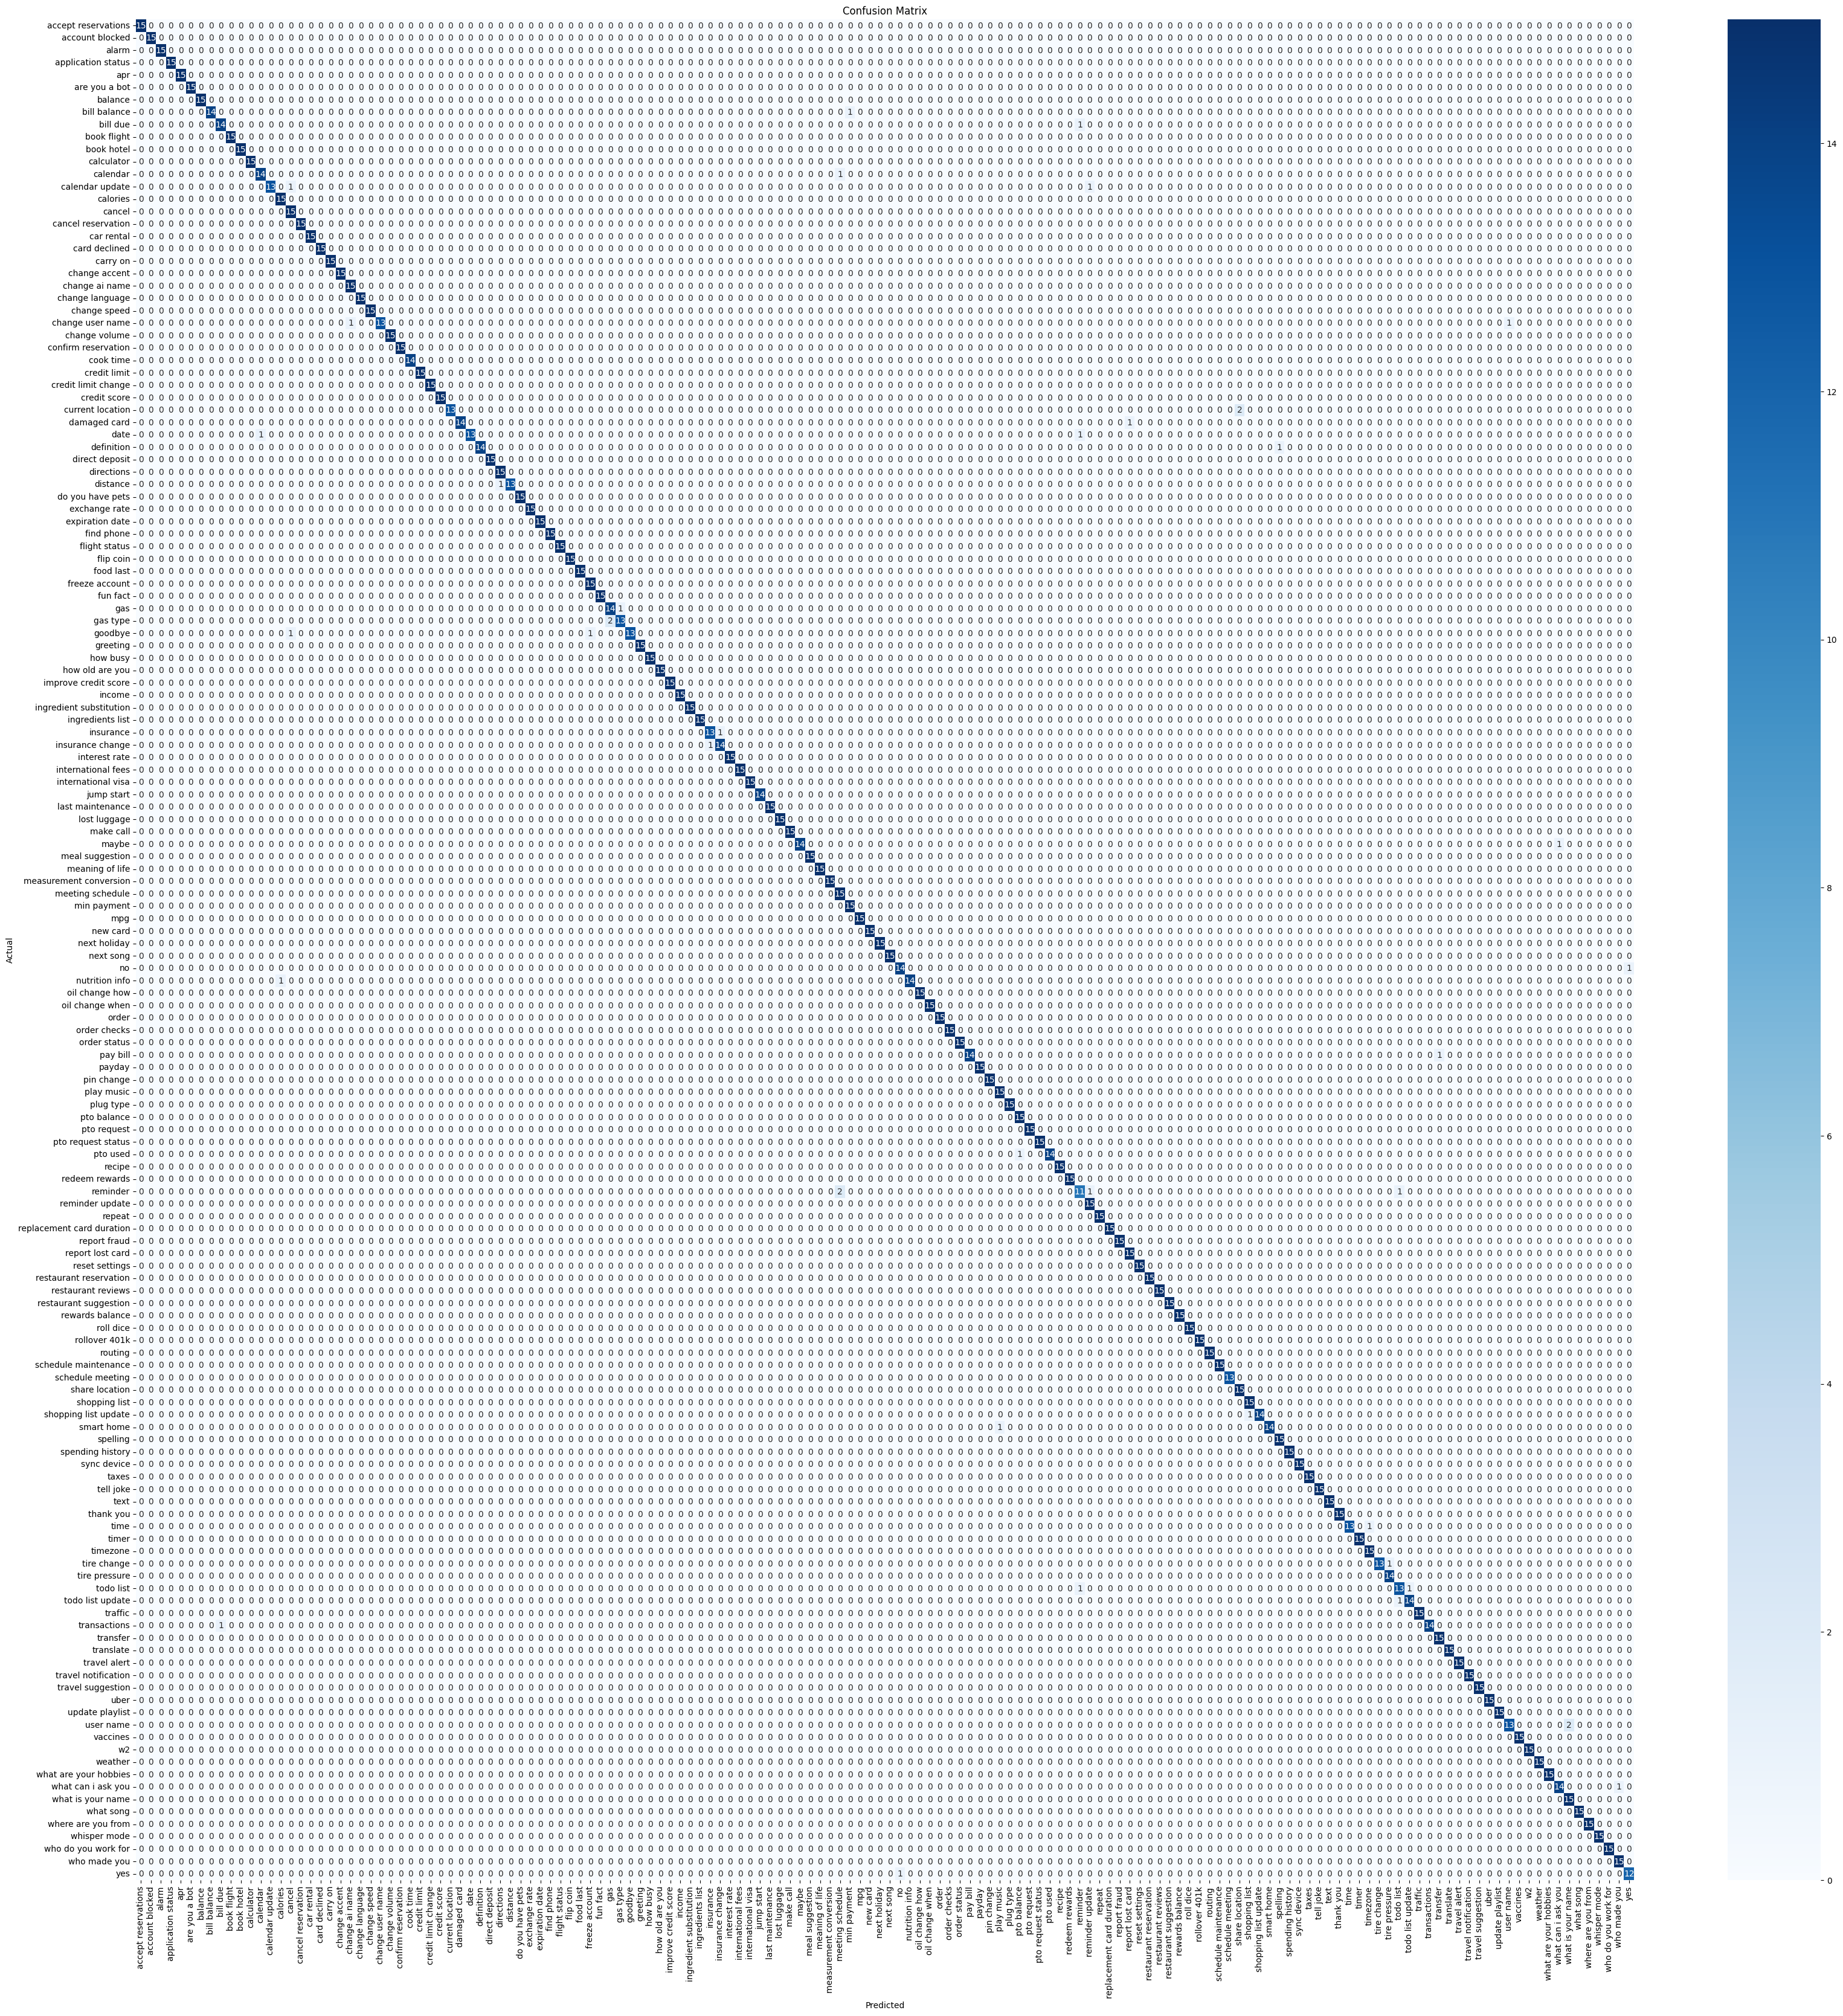

In [45]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix


# Calculate the confusion matrix
confusion = confusion_matrix(labels, prediction)

# Create a heatmap of the confusion matrix
plt.figure(figsize=(40, 40))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', 
            xticklabels=[id2int[x] for x in range(150)], 
            yticklabels=[id2int[x] for x in range(150)])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [46]:
conf = torch.tensor(confusion)
conf = conf.argsort(dim=1, descending=True)

In [47]:
confusion

array([[15,  0,  0, ...,  0,  0,  0],
       [ 0, 15,  0, ...,  0,  0,  0],
       [ 0,  0, 15, ...,  0,  0,  0],
       ...,
       [ 0,  0,  0, ..., 15,  0,  0],
       [ 0,  0,  0, ...,  0, 15,  0],
       [ 0,  0,  0, ...,  0,  0, 12]])

In [48]:
conf

tensor([[  0,  94, 111,  ...,  52,  53,  54],
        [  1,  95, 112,  ...,  53,  54,  55],
        [  2, 104,  95,  ...,  53,  54,  55],
        ...,
        [147, 103,  94,  ...,  53,  54,  55],
        [148, 103,  94,  ...,  53,  54,  55],
        [149,  76, 103,  ...,  53,  54,  55]])

In [49]:
confusion.shape

(150, 150)

In [50]:
import pickle

# Define the file name for saving the confusion matrix as a pickle
file_name = "confusion_matrix.pkl"

# Open the file in binary write mode
with open(file_name, "wb") as file:
    pickle.dump(conf, file)

print("Confusion Matrix saved as 'confusion_matrix.pkl'")

Confusion Matrix saved as 'confusion_matrix.pkl'


In [51]:
import pickle

# Load the confusion matrix from the pickle file
with open("confusion_matrix.pkl", "rb") as file:
    loaded_confusion = pickle.load(file)

In [52]:
jk

[15,
 30,
 45,
 60,
 75,
 90,
 105,
 120,
 135,
 150,
 165,
 180,
 195,
 210,
 225,
 240,
 255,
 270,
 285,
 300,
 315,
 330,
 345,
 360,
 375,
 390,
 405,
 419,
 434,
 449,
 464,
 479,
 494,
 509,
 524,
 539,
 554,
 568,
 583,
 598,
 613,
 628,
 643,
 658,
 673,
 688,
 703,
 718,
 733,
 748,
 763,
 778,
 793,
 808,
 823,
 838,
 853,
 867,
 882,
 897,
 912,
 927,
 941,
 956,
 971,
 986,
 1001,
 1016,
 1031,
 1046,
 1061,
 1076,
 1091,
 1106,
 1121,
 1136,
 1151,
 1166,
 1181,
 1196,
 1211,
 1226,
 1241,
 1256,
 1271,
 1286,
 1301,
 1316,
 1331,
 1346,
 1361,
 1376,
 1391,
 1406,
 1421,
 1436,
 1451,
 1466,
 1481,
 1496,
 1511,
 1526,
 1541,
 1556,
 1571,
 1586,
 1601,
 1616,
 1631,
 1644,
 1659,
 1674,
 1689,
 1704,
 1719,
 1734,
 1749,
 1764,
 1779,
 1794,
 1809,
 1823,
 1838,
 1853,
 1867,
 1881,
 1896,
 1911,
 1926,
 1941,
 1956,
 1971,
 1986,
 2001,
 2016,
 2031,
 2046,
 2061,
 2076,
 2091,
 2106,
 2121,
 2136,
 2151,
 2166,
 2181,
 2196,
 2211,
 2226,
 2239]

In [53]:
prev = 0
out = []
for j in list(jk):
    sms = softmax_tensor[prev:j, :].mean(dim=0)
    out.append(list(sms))
    prev = j

In [54]:
out = torch.tensor(out)

In [55]:
confidence = out.argsort(dim=1, descending=True).tolist()

In [56]:
file_name = "confidence_matrix.pkl"

# Open the file in binary write mode
with open(file_name, "wb") as file:
    pickle.dump(confidence, file)

print("Confidence Matrix saved as 'confidence_matrix.pkl'")

Confidence Matrix saved as 'confidence_matrix.pkl'


In [57]:
cnfid = {}
for i, esd in enumerate(confidence):
    cnfid[i] = [id2int[x] for x in esd]


In [58]:
for i in range(20):
    print(f"{id2int[i]}: {cnfid[i][1:11]}")

accept reservations: ['restaurant reservation', 'confirm reservation', 'how busy', 'book hotel', 'cancel reservation', 'restaurant suggestion', 'schedule meeting', 'restaurant reviews', 'car rental', 'share location']
account blocked: ['freeze account', 'balance', 'card declined', 'report fraud', 'damaged card', 'payday', 'rollover 401k', 'report lost card', 'expiration date', 'pin change']
alarm: ['smart home', 'timer', 'reminder update', 'calendar update', 'calendar', 'reminder', 'schedule maintenance', 'make call', 'schedule meeting', 'sync device']
application status: ['pto request status', 'flight status', 'new card', 'replacement card duration', 'expiration date', 'international visa', 'order status', 'w2', 'insurance', 'report lost card']
apr: ['credit limit', 'interest rate', 'credit limit change', 'new card', 'transactions', 'taxes', 'credit score', 'improve credit score', 'expiration date', 'application status']
are you a bot: ['who made you', 'how old are you', 'goodbye', 't

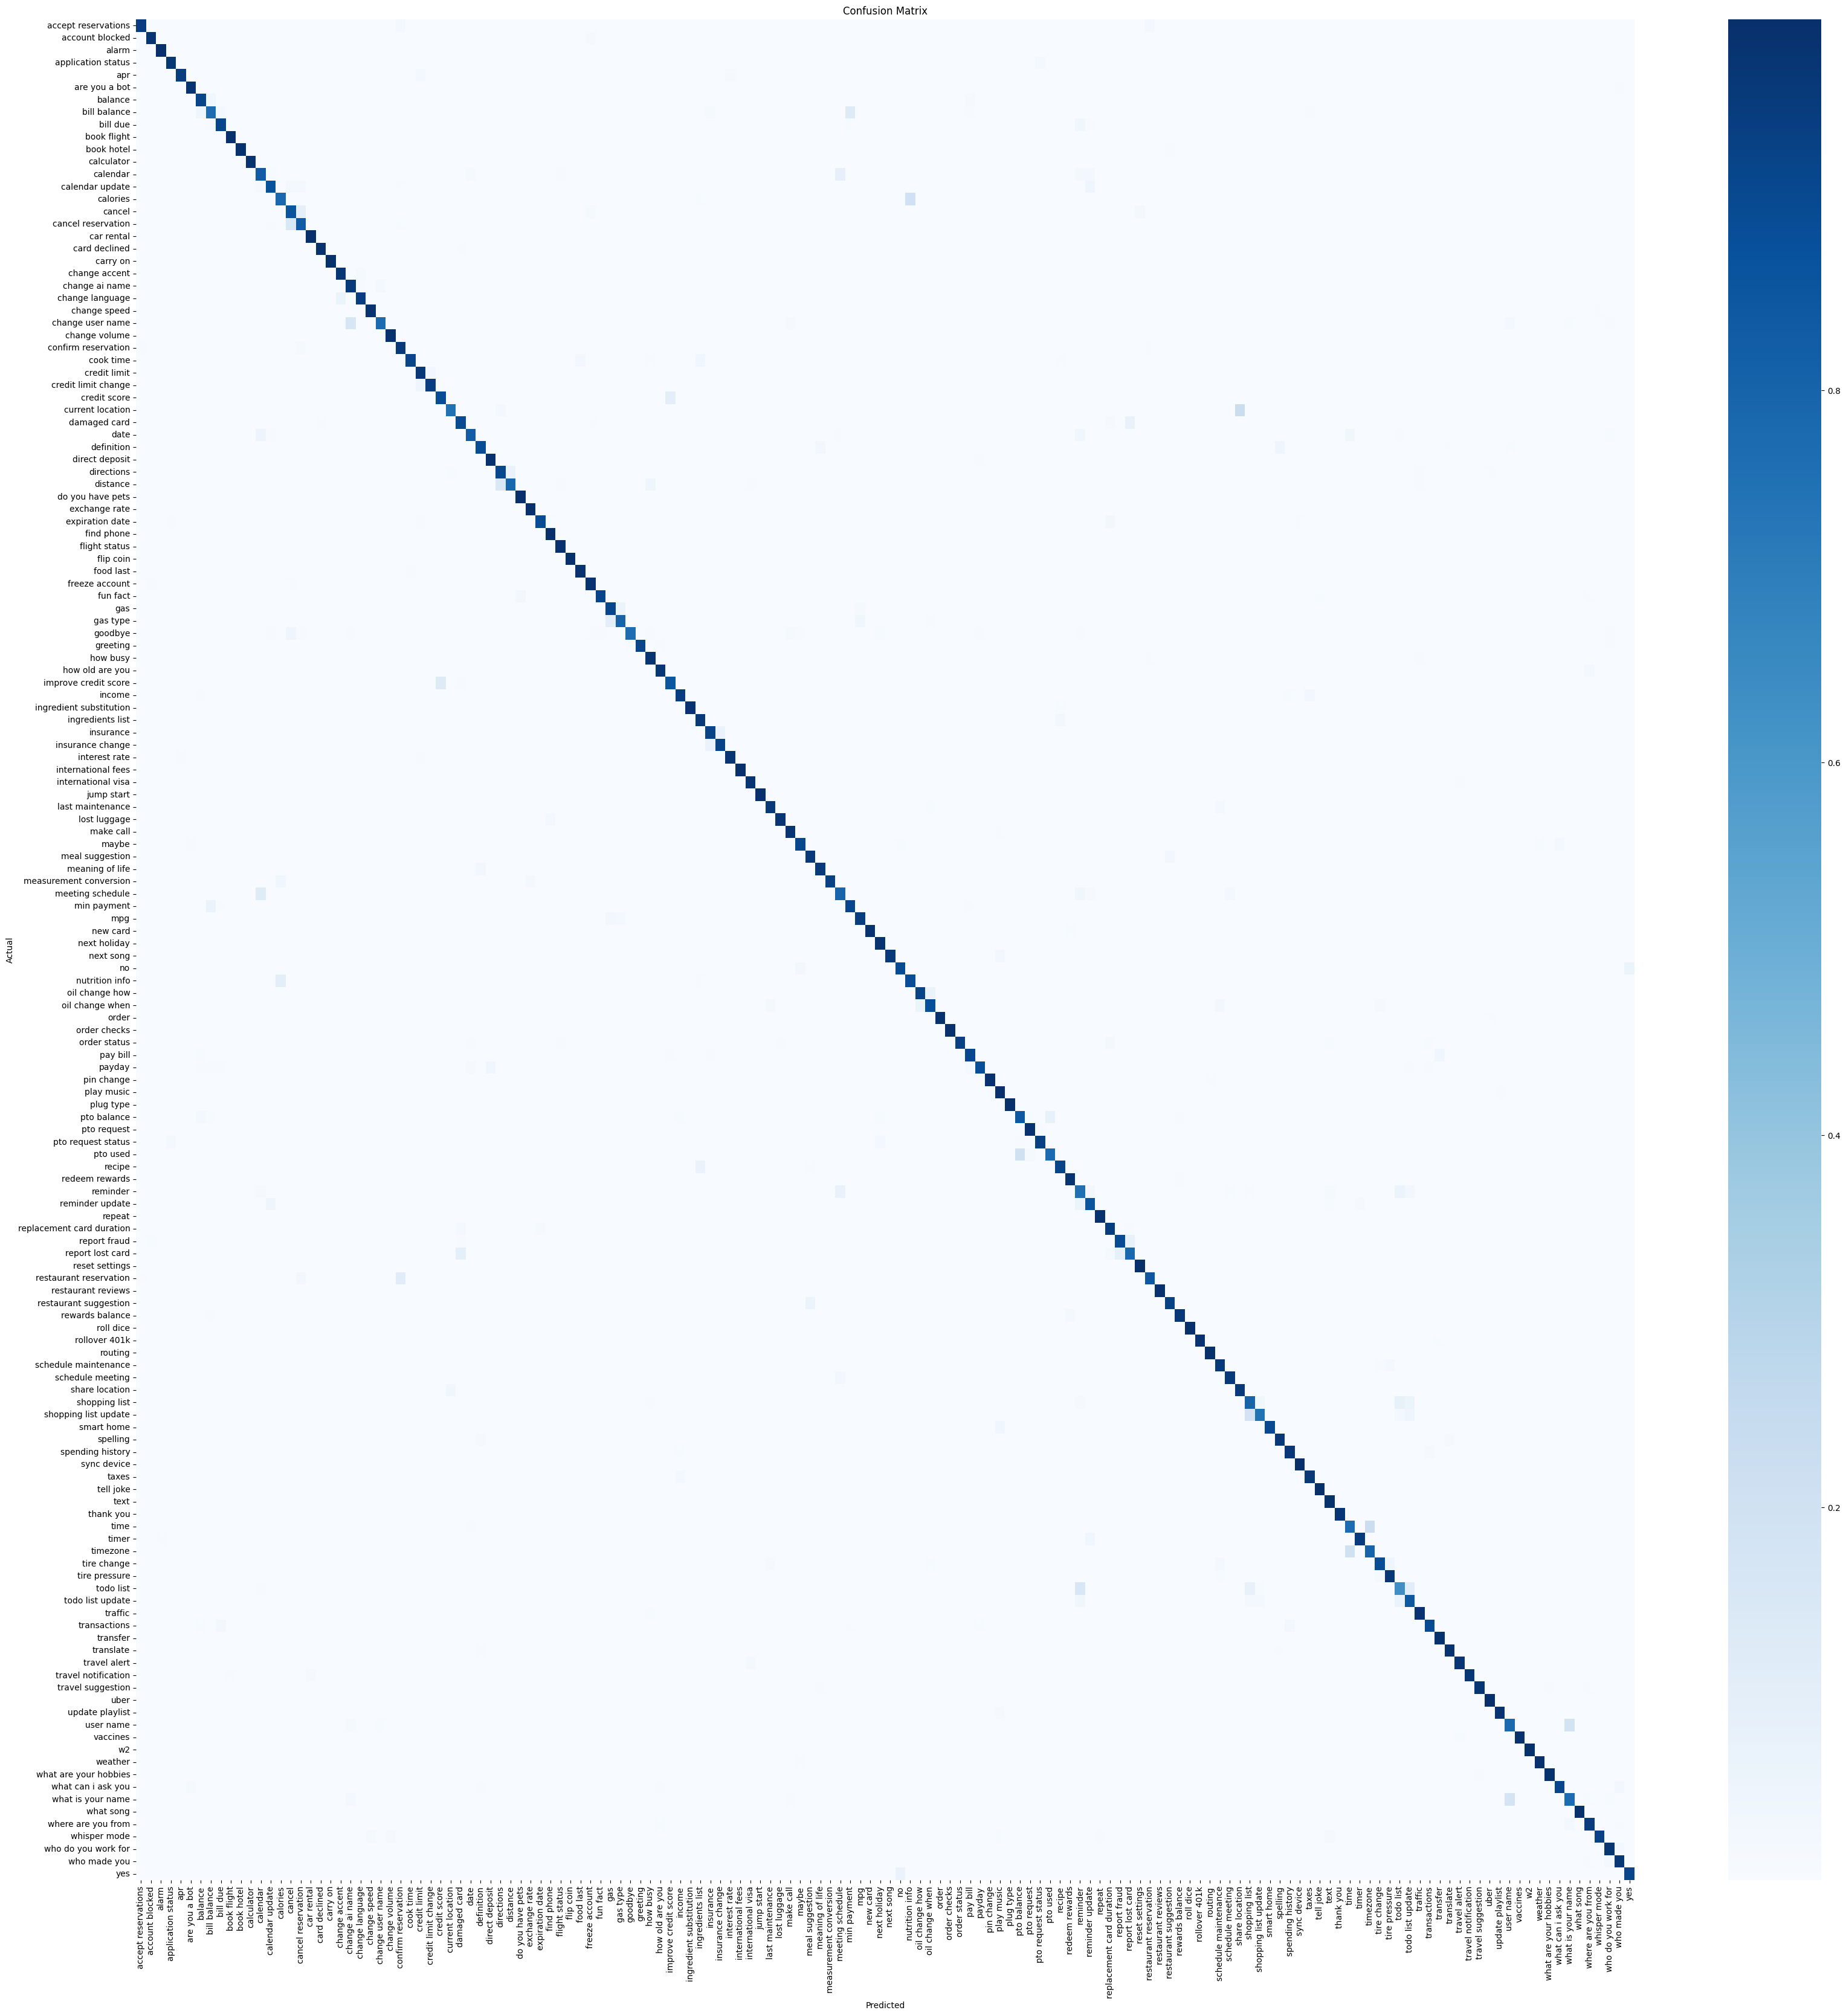

In [60]:
plt.figure(figsize=(40, 40))
sns.heatmap(out, annot=False, fmt='.2f', cmap='Blues', 
            xticklabels=[id2int[x] for x in range(150)], 
            yticklabels=[id2int[x] for x in range(150)])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [124]:
i = 56
print(f"{id2int[i]}: {cnfid[i][1:11]}")

ingredients list: ['recipe', 'nutrition info', 'cook time', 'calories', 'ingredient substitution', 'spelling', 'food last', 'fun fact', 'meal suggestion', 'what can i ask you']


{'accept reservations': ['accept reservations',
  'restaurant reservation',
  'confirm reservation',
  'book hotel',
  'cancel reservation',
  'how busy',
  'schedule meeting',
  'restaurant reviews',
  'restaurant suggestion',
  'share location',
  'routing',
  'meeting schedule',
  'current location',
  'car rental',
  'date',
  'book flight',
  'calendar',
  'cancel',
  'maybe',
  'pto request',
  'travel suggestion',
  'fun fact',
  'meal suggestion',
  'expiration date',
  'w2',
  'insurance',
  'credit score',
  'uber',
  'no',
  'do you have pets',
  'yes',
  'application status',
  'find phone',
  'international visa',
  'pto request status',
  'directions',
  'pto balance',
  'reminder',
  'spelling',
  'travel notification',
  'carry on',
  'calendar update',
  'recipe',
  'translate',
  'order checks',
  'nutrition info',
  'greeting',
  'who do you work for',
  'order',
  'where are you from',
  'flight status',
  'order status',
  'apr',
  'lost luggage',
  'next holiday',

In [21]:
dct = {"id": [], "intent": []}
for i, j in enumerate(list(prediction)):
    dct["id"].append(i)
    dct["intent"].append(j)


In [22]:
def dict_to_dataset(dict):
    dataset = datasets.Dataset.from_dict(dict)
    return dataset

pred = dict_to_dataset(dct)
pred.save_to_disk(f"pred_xlmr")

Saving the dataset (0/1 shards):   0%|          | 0/2239 [00:00<?, ? examples/s]

In [23]:
acc_lst = labels == prediction

In [24]:
print(f"Accuracy = {acc_lst.sum()/2239}")

Accuracy = 0.8311746120452881


In [43]:
labels.view(-1, 1) in torch.argsort(scores, dim=1)[:, :10]

True

In [46]:
prediction

tensor([101, 109,   3,  ...,  47,   6,   3])